In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = '../data/data_markedup_clear.tsv'

data = pd.read_csv(data_path, encoding='utf-8', sep='\t')

In [3]:
data

,cash,description,type
0,15300.0,За участие в конференции в г. Майкоп по догово...,SERVICE
1,40200.0,За оказание услуг по договору №79-02726В от 01...,SERVICE
2,1440.0,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS
3,240000000.0,Возврат денежных средств по договору займа №04...,LOAN
4,1360000.0,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED
...,...,...,...
494,2610.0,Оплата налогов,TAX
495,31200.0,Комиссия за выполнение функций агента валютног...,BANK_SERVICE
496,18200.0,За тур.поездку по договору №75-04243Г от 24/04...,SERVICE
497,2870000.0,"Оплата по договору №095 от 24.02.2025г, счету ...",FOOD_GOODS


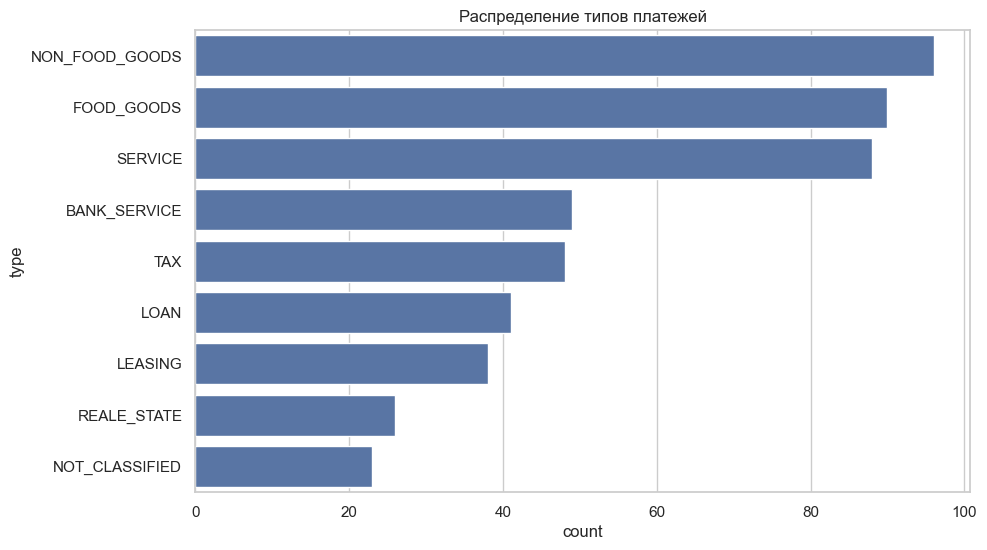

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(y='type', data=data, order=data['type'].value_counts().index)
plt.title('Распределение типов платежей')
plt.show()

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

c:\Users\usern\Desktop\Projects\payment-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
X = data.drop(columns=['type'])
y = data['type'] 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [16]:
X_train

,cash,description
0,18100.0,Оплата по Счету 0119 от 22.06.2023г. за возмещ...
1,1510000.0,ПРЕДОПЛАТА ПО ДОГ. 33.167220-АБ за Раствор вод...
2,27300.0,Оплата по договору 96.056729-ЕЕ от 25.01.2026 ...
3,980.0,Оплата за Мармелад Mix Bar жевательный со вкус...
4,22400.0,Оплата основного долга за период с 19.10.2024г...
...,...,...
394,1770.0,"Оплата за Восточные сладости, халва по счету 1..."
395,26800.0,Оказание прочих услуг
396,3430.0,Перевод средств на собственный счет
397,3580.0,Оплата за Масло оливковое Global Village Class...


In [17]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

texts = X_train['description'].tolist()

batch_dict = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**batch_dict)

def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    ''' 
    Функция average_pool выполняет усреднение скрытых состояний последнего слоя модели, 
    учитывая маску внимания. 

    Параметры:
    - last_hidden_states: Тензор, содержащий скрытые состояния последнего слоя модели. 
      Размерность тензора - (batch_size, sequence_length, hidden_size).
    - attention_mask: Тензор, указывающий, какие токены следует учитывать при усреднении. 
      Размерность тензора - (batch_size, sequence_length).

    Возвращает:
    - Тензор, представляющий усредненные эмбеддинги для каждого примера в батче. 
      Размерность тензора - (batch_size, hidden_size).
    
    Процесс:
    1. Скрытые состояния, соответствующие токенам, которые не должны учитываться (например, паддинг), 
       заменяются на нули с помощью метода masked_fill.
    2. Затем выполняется суммирование скрытых состояний по временной оси (dim=1).
    3. Наконец, результат делится на количество токенов, которые были учтены (сумма маски внимания), 
       чтобы получить усредненные эмбеддинги.
    '''
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

embeddings = F.normalize(embeddings, p=2, dim=1)

In [18]:
embeddings_df = pd.DataFrame(embeddings.numpy(), columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

df_train = pd.concat([X_train.drop(columns=['description']), embeddings_df], axis=1)

df_train

,cash,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1014,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023
0,18100.0,0.020523,0.040709,-0.033970,-0.044322,0.008434,-0.035249,-0.013526,0.074740,0.065052,...,-0.035134,-0.036991,0.007678,-0.019576,-0.002962,0.012326,0.039922,-0.012766,-0.064180,0.033214
1,1510000.0,0.000743,0.014424,-0.009921,-0.045274,0.028659,-0.028442,-0.025680,0.094850,0.032821,...,-0.032908,-0.056404,0.001737,0.013927,0.005344,0.009987,0.015614,-0.022074,-0.057787,0.018353
2,27300.0,-0.001666,0.003251,-0.008760,-0.036255,0.016661,-0.013160,-0.010342,0.064050,0.051714,...,-0.015180,-0.039819,0.027336,0.005327,-0.005465,0.003971,0.023492,-0.026969,-0.071755,0.019129
3,980.0,0.006339,0.023167,0.002278,-0.033423,0.009336,-0.006112,-0.030485,0.069060,0.046973,...,-0.032568,-0.023713,0.018828,-0.017963,-0.018346,-0.002187,0.033898,-0.001137,-0.071004,0.024150
4,22400.0,0.014310,0.033121,-0.023073,-0.057502,0.002922,-0.017478,-0.012524,0.074013,0.038357,...,-0.026167,-0.030555,0.040927,-0.024585,0.002257,0.001336,0.030971,-0.004247,-0.046458,-0.004472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,1770.0,0.009767,0.018648,-0.005370,-0.058525,0.006666,0.002307,-0.017849,0.063421,0.034205,...,-0.054562,-0.035932,0.013331,-0.033041,-0.014811,0.001203,0.017732,-0.014737,-0.076332,0.015579
395,26800.0,-0.019700,0.021117,0.002330,-0.034044,0.023165,0.020270,-0.007891,0.085033,0.050195,...,-0.022978,-0.042264,0.022523,-0.013771,0.015903,0.023520,0.056897,-0.038377,-0.027221,0.004273
396,3430.0,0.023995,0.021914,-0.001825,-0.025168,0.009033,0.009581,0.004618,0.066724,0.053036,...,-0.032107,-0.026036,0.032014,-0.034531,0.011661,0.028611,0.015973,-0.034071,-0.030322,0.016813
397,3580.0,-0.006936,0.035419,-0.017371,-0.044045,0.025342,-0.049800,-0.016671,0.061549,0.038452,...,-0.028316,-0.026957,0.016313,-0.005173,-0.014632,0.004766,-0.000373,0.002961,-0.047724,-0.006403


In [19]:
df_train.to_csv('../data/X_train_embeded.csv', index=False)

In [20]:
texts_test = X_test['description'].tolist()
batch_dict_test = tokenizer(texts_test, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs_test = model(**batch_dict_test)

embeddings_test = average_pool(outputs_test.last_hidden_state, batch_dict_test['attention_mask'])

embeddings_test = F.normalize(embeddings_test, p=2, dim=1)

embeddings_df_test = pd.DataFrame(embeddings_test.numpy(), columns=[f'embedding_{i}' for i in range(embeddings_test.shape[1])])

df_test = pd.concat([X_test.drop(columns=['description']), embeddings_df_test], axis=1)

df_test

,cash,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1014,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023
0,4970.0,0.000674,0.028599,-0.026564,-0.050681,0.009340,-0.025542,-0.022700,0.072545,0.041932,...,-0.052210,-0.041714,0.011837,-0.030672,-0.014087,0.016767,0.032308,-0.023216,-0.061905,0.009807
1,28500.0,-0.019700,0.021117,0.002330,-0.034044,0.023165,0.020270,-0.007891,0.085033,0.050195,...,-0.022978,-0.042264,0.022523,-0.013771,0.015903,0.023520,0.056897,-0.038377,-0.027221,0.004273
2,4940.0,0.000339,0.038553,-0.016406,-0.058173,0.011587,0.005829,-0.032784,0.062265,0.066106,...,-0.036492,-0.024033,0.014651,-0.025573,-0.006300,0.007621,0.025045,-0.002548,-0.089352,0.002141
3,1420.0,-0.002826,0.025511,-0.024769,-0.061766,0.001735,-0.010528,-0.038837,0.081550,0.048864,...,-0.007404,-0.039179,0.034745,0.009638,0.012058,0.000374,0.021318,-0.019007,-0.044825,-0.002360
4,104000000.0,-0.015708,0.018838,-0.009022,-0.032259,0.002752,-0.003388,-0.002239,0.088438,0.028098,...,-0.013890,-0.049279,0.030438,-0.004430,0.002190,0.024921,-0.003478,-0.024549,-0.093313,0.010281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,355000000.0,-0.023354,0.023289,-0.000605,-0.037887,0.002883,-0.008375,-0.004917,0.094561,0.036220,...,-0.005436,-0.032944,0.017453,-0.008379,0.004395,0.013418,0.013728,-0.018178,-0.098237,-0.005624
96,1260000.0,-0.039453,0.027827,-0.018504,-0.046055,0.002662,0.009101,-0.001360,0.067767,0.031469,...,-0.017332,-0.047077,0.032923,-0.014898,-0.002083,0.010408,0.041601,-0.027087,-0.048033,-0.012508
97,3150000.0,0.014491,0.031431,-0.040219,-0.042397,0.003649,-0.011269,-0.010674,0.077913,0.055304,...,-0.015153,-0.040189,0.030400,-0.011483,-0.002087,0.005161,0.039150,-0.025675,-0.083326,0.025402
98,36200.0,-0.014234,0.023472,0.018126,-0.058333,0.007357,0.006306,-0.023689,0.067317,0.035385,...,-0.029699,-0.050363,0.007964,-0.000567,-0.000780,-0.002599,0.040836,-0.033245,-0.061454,0.011757


In [21]:
df_test.to_csv('../data/X_test_embeded.csv', index=False)

In [ ]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    verbose=100,
    early_stopping_rounds=50
)

cb_model.fit(df_train, y_train)

0:	learn: 2.0978112	total: 743ms	remaining: 12m 22s
100:	learn: 0.1336609	total: 49.6s	remaining: 7m 21s
200:	learn: 0.0449149	total: 1m 37s	remaining: 6m 26s
300:	learn: 0.0256698	total: 2m 23s	remaining: 5m 34s
400:	learn: 0.0168924	total: 3m 9s	remaining: 4m 43s
500:	learn: 0.0125347	total: 3m 55s	remaining: 3m 54s
600:	learn: 0.0098576	total: 4m 42s	remaining: 3m 7s
700:	learn: 0.0081345	total: 5m 29s	remaining: 2m 20s
800:	learn: 0.0069516	total: 6m 17s	remaining: 1m 33s
900:	learn: 0.0060727	total: 7m 3s	remaining: 46.5s
999:	learn: 0.0053620	total: 7m 49s	remaining: 0us


In [24]:
from sklearn.metrics import classification_report

y_pred = cb_model.predict(df_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

  BANK_SERVICE       1.00      1.00      1.00        10
    FOOD_GOODS       0.95      1.00      0.97        18
       LEASING       1.00      1.00      1.00         8
          LOAN       1.00      1.00      1.00         8
NON_FOOD_GOODS       1.00      0.95      0.97        19
NOT_CLASSIFIED       1.00      1.00      1.00         4
   REALE_STATE       1.00      1.00      1.00         5
       SERVICE       1.00      1.00      1.00        18
           TAX       1.00      1.00      1.00        10

      accuracy                           0.99       100
     macro avg       0.99      0.99      0.99       100
  weighted avg       0.99      0.99      0.99       100

